---
## Section 1: Environment Setup

### Check GPU Availability and Install Dependencies

In [1]:
# Check if GPU is available
!nvidia-smi

Tue Nov 25 10:18:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install required packages
!pip install numpy matplotlib -q

In [3]:
# Import libraries
import os
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
from typing import Tuple, List

print("NumPy version:", np.__version__)
print("CuPy version:", cp.__version__)
print("GPU Device:", cp.cuda.runtime.getDeviceProperties(0)['name'].decode())
print("CUDA Version:", cp.cuda.runtime.runtimeGetVersion())

NumPy version: 1.26.4
CuPy version: 13.6.0
GPU Device: Tesla P100-PCIE-16GB
CUDA Version: 12090


---
## Section 2: AES Constants and Lookup Tables

### S-Box, Inverse S-Box, Round Constants, and Galois Field Tables

In [4]:
# AES S-Box (Substitution Box) - used in SubBytes transformation
S_BOX = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
], dtype=np.uint8)

# Inverse S-Box - used in decryption
INV_S_BOX = np.array([
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
], dtype=np.uint8)

# Round constants for key expansion
RCON = np.array([
    0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36, 0x6C, 0xD8, 0xAB, 0x4D, 0x9A,
    0x2F, 0x5E, 0xBC, 0x63, 0xC6, 0x97, 0x35, 0x6A, 0xD4, 0xB3, 0x7D, 0xFA, 0xEF, 0xC5, 0x91, 0x39,
    0x72, 0xE4, 0xD3, 0xBD, 0x61, 0xC2, 0x9F, 0x25, 0x4A, 0x94, 0x33, 0x66, 0xCC, 0x83, 0x1D, 0x3A,
    0x74, 0xE8, 0xCB, 0x8D, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36, 0x6C, 0xD8,
    0xAB, 0x4D, 0x9A, 0x2F, 0x5E, 0xBC, 0x63, 0xC6, 0x97, 0x35, 0x6A, 0xD4, 0xB3, 0x7D, 0xFA, 0xEF,
    0xC5, 0x91, 0x39, 0x72, 0xE4, 0xD3, 0xBD, 0x61, 0xC2, 0x9F, 0x25, 0x4A, 0x94, 0x33, 0x66, 0xCC,
    0x83, 0x1D, 0x3A, 0x74, 0xE8, 0xCB, 0x8D, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B,
    0x36, 0x6C, 0xD8, 0xAB, 0x4D, 0x9A, 0x2F, 0x5E, 0xBC, 0x63, 0xC6, 0x97, 0x35, 0x6A, 0xD4, 0xB3,
    0x7D, 0xFA, 0xEF, 0xC5, 0x91, 0x39, 0x72, 0xE4, 0xD3, 0xBD, 0x61, 0xC2, 0x9F, 0x25, 0x4A, 0x94,
    0x33, 0x66, 0xCC, 0x83, 0x1D, 0x3A, 0x74, 0xE8, 0xCB, 0x8D, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20,
    0x40, 0x80, 0x1B, 0x36, 0x6C, 0xD8, 0xAB, 0x4D, 0x9A, 0x2F, 0x5E, 0xBC, 0x63, 0xC6, 0x97, 0x35,
    0x6A, 0xD4, 0xB3, 0x7D, 0xFA, 0xEF, 0xC5, 0x91, 0x39, 0x72, 0xE4, 0xD3, 0xBD, 0x61, 0xC2, 0x9F,
    0x25, 0x4A, 0x94, 0x33, 0x66, 0xCC, 0x83, 0x1D, 0x3A, 0x74, 0xE8, 0xCB, 0x8D, 0x01, 0x02, 0x04,
    0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36, 0x6C, 0xD8, 0xAB, 0x4D, 0x9A, 0x2F, 0x5E, 0xBC, 0x63,
    0xC6, 0x97, 0x35, 0x6A, 0xD4, 0xB3, 0x7D, 0xFA, 0xEF, 0xC5, 0x91, 0x39, 0x72, 0xE4, 0xD3, 0xBD,
    0x61, 0xC2, 0x9F, 0x25, 0x4A, 0x94, 0x33, 0x66, 0xCC, 0x83, 0x1D, 0x3A, 0x74, 0xE8, 0xCB, 0x8D
], dtype=np.uint8)

# Galois Field multiplication lookup tables
def generate_gmul_table(multiplier):
    """Generate Galois Field GF(2^8) multiplication table"""
    table = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        p = 0
        a = i
        b = multiplier
        for _ in range(8):
            if b & 1:
                p ^= a
            hi_bit_set = a & 0x80
            a = (a << 1) & 0xFF
            if hi_bit_set:
                a ^= 0x1B  # Irreducible polynomial
            b >>= 1
        table[i] = p
    return table

GMUL_2 = generate_gmul_table(2)
GMUL_3 = generate_gmul_table(3)
GMUL_9 = generate_gmul_table(9)
GMUL_11 = generate_gmul_table(11)
GMUL_13 = generate_gmul_table(13)
GMUL_14 = generate_gmul_table(14)

print("AES Constants loaded successfully")
print(f"   S-Box size: {len(S_BOX)} bytes")
print(f"   Galois Field tables: 6 tables x 256 bytes")

AES Constants loaded successfully
   S-Box size: 256 bytes
   Galois Field tables: 6 tables x 256 bytes


---
## Section 3: CPU Implementation

### Complete AES-128 CPU Implementation with ECB and CTR Modes

In [5]:
class AES_CPU:
    """AES-128 implementation for CPU using pure Python/NumPy"""

    def __init__(self, key):
        if isinstance(key, bytes):
            key = np.frombuffer(key, dtype=np.uint8)
        assert len(key) == 16, "Key must be 128 bits (16 bytes)"
        self.key = np.array(key, dtype=np.uint8)
        self.round_keys = self._key_expansion(self.key)

    def _key_expansion(self, key):
        """Expand 128-bit key into 11 round keys (176 bytes)"""
        expanded_key = np.zeros(176, dtype=np.uint8)
        expanded_key[:16] = key

        bytes_generated = 16
        rcon_iteration = 1
        temp = np.zeros(4, dtype=np.uint8)

        while bytes_generated < 176:
            for i in range(4):
                temp[i] = expanded_key[bytes_generated - 4 + i]

            if bytes_generated % 16 == 0:
                # Rotate
                k = temp[0]
                temp[0] = temp[1]
                temp[1] = temp[2]
                temp[2] = temp[3]
                temp[3] = k

                # S-box substitution
                for i in range(4):
                    temp[i] = S_BOX[temp[i]]

                # XOR with round constant
                temp[0] ^= RCON[rcon_iteration]
                rcon_iteration += 1

            for i in range(4):
                expanded_key[bytes_generated] = expanded_key[bytes_generated - 16] ^ temp[i]
                bytes_generated += 1

        return expanded_key

    def _add_round_key(self, state, round_key):
        return state ^ round_key

    def _sub_bytes(self, state):
        return S_BOX[state]

    def _inv_sub_bytes(self, state):
        return INV_S_BOX[state]

    def _shift_rows(self, state):
      """ShiftRows transformation - works on rows of column-major matrix"""
      state_matrix = state.reshape(4, 4, order='F')  # Column-major: [s0,s1,s2,s3] is col 0
      shifted = np.zeros((4, 4), dtype=np.uint8)

      # In column-major, matrix[row, col] accesses correctly
      # Row 0: no shift
      shifted[0, :] = state_matrix[0, :]
      # Row 1: shift left by 1
      shifted[1, :] = np.roll(state_matrix[1, :], -1)
      # Row 2: shift left by 2
      shifted[2, :] = np.roll(state_matrix[2, :], -2)
      # Row 3: shift left by 3
      shifted[3, :] = np.roll(state_matrix[3, :], -3)

      return shifted.flatten(order='F')

    def _inv_shift_rows(self, state):
      """Inverse ShiftRows transformation"""
      state_matrix = state.reshape(4, 4, order='F')
      shifted = np.zeros((4, 4), dtype=np.uint8)

      # Row 0: no shift
      shifted[0, :] = state_matrix[0, :]
      # Row 1: shift right by 1 (or left by 3)
      shifted[1, :] = np.roll(state_matrix[1, :], 1)
      # Row 2: shift right by 2
      shifted[2, :] = np.roll(state_matrix[2, :], 2)
      # Row 3: shift right by 3 (or left by 1)
      shifted[3, :] = np.roll(state_matrix[3, :], 3)

      return shifted.flatten(order='F')

    def _mix_columns(self, state):
        """MixColumns transformation - vectorized for all columns at once"""
        state_matrix = state.reshape(4, 4, order='F')
        result = np.zeros((4, 4), dtype=np.uint8)
        
        # Vectorized version - process all columns at once
        s0 = state_matrix[0, :]
        s1 = state_matrix[1, :]
        s2 = state_matrix[2, :]
        s3 = state_matrix[3, :]
        
        result[0, :] = GMUL_2[s0] ^ GMUL_3[s1] ^ s2 ^ s3
        result[1, :] = s0 ^ GMUL_2[s1] ^ GMUL_3[s2] ^ s3
        result[2, :] = s0 ^ s1 ^ GMUL_2[s2] ^ GMUL_3[s3]
        result[3, :] = GMUL_3[s0] ^ s1 ^ s2 ^ GMUL_2[s3]
        
        return result.flatten(order='F')
    
    def _inv_mix_columns(self, state):
        """Inverse MixColumns transformation - vectorized for all columns at once"""
        state_matrix = state.reshape(4, 4, order='F')
        result = np.zeros((4, 4), dtype=np.uint8)
        
        # Vectorized version - process all columns at once
        s0 = state_matrix[0, :]
        s1 = state_matrix[1, :]
        s2 = state_matrix[2, :]
        s3 = state_matrix[3, :]
        
        result[0, :] = GMUL_14[s0] ^ GMUL_11[s1] ^ GMUL_13[s2] ^ GMUL_9[s3]
        result[1, :] = GMUL_9[s0] ^ GMUL_14[s1] ^ GMUL_11[s2] ^ GMUL_13[s3]
        result[2, :] = GMUL_13[s0] ^ GMUL_9[s1] ^ GMUL_14[s2] ^ GMUL_11[s3]
        result[3, :] = GMUL_11[s0] ^ GMUL_13[s1] ^ GMUL_9[s2] ^ GMUL_14[s3]
        
        return result.flatten(order='F')
        
    def _encrypt_block(self, block):
        state = block.copy()

        # Initial round
        state = self._add_round_key(state, self.round_keys[0:16])

        # 9 main rounds
        for round_num in range(1, 10):
            state = self._sub_bytes(state)
            state = self._shift_rows(state)
            state = self._mix_columns(state)
            round_key = self.round_keys[round_num * 16:(round_num + 1) * 16]
            state = self._add_round_key(state, round_key)

        # Final round (no MixColumns)
        state = self._sub_bytes(state)
        state = self._shift_rows(state)
        state = self._add_round_key(state, self.round_keys[160:176])

        return state

    def _decrypt_block(self, block):
        state = block.copy()

        # Initial round
        state = self._add_round_key(state, self.round_keys[160:176])
        state = self._inv_shift_rows(state)
        state = self._inv_sub_bytes(state)

        # 9 main rounds
        for round_num in range(9, 0, -1):
            round_key = self.round_keys[round_num * 16:(round_num + 1) * 16]
            state = self._add_round_key(state, round_key)
            state = self._inv_mix_columns(state)
            state = self._inv_shift_rows(state)
            state = self._inv_sub_bytes(state)

        # Final round
        state = self._add_round_key(state, self.round_keys[0:16])

        return state

    def encrypt_ecb(self, plaintext):
        """Encrypt using ECB mode"""
        if isinstance(plaintext, bytes):
            plaintext = np.frombuffer(plaintext, dtype=np.uint8)

        # PKCS7 padding
        pad_len = 16 - (len(plaintext) % 16)
        plaintext = np.concatenate([plaintext, np.full(pad_len, pad_len, dtype=np.uint8)])

        ciphertext = np.zeros(len(plaintext), dtype=np.uint8)

        for i in range(0, len(plaintext), 16):
            block = plaintext[i:i+16]
            ciphertext[i:i+16] = self._encrypt_block(block)

        return ciphertext

    def decrypt_ecb(self, ciphertext):
        """Decrypt using ECB mode with safe padding removal"""
        if isinstance(ciphertext, bytes):
            ciphertext = np.frombuffer(ciphertext, dtype=np.uint8)

        assert len(ciphertext) % 16 == 0

        plaintext = np.zeros(len(ciphertext), dtype=np.uint8)

        for i in range(0, len(ciphertext), 16):
            block = ciphertext[i:i+16]
            plaintext[i:i+16] = self._decrypt_block(block)

        # Remove PKCS7 padding safely
        pad_len = int(plaintext[-1])
        if 1 <= pad_len <= 16:
            # Validate padding
            if np.all(plaintext[-pad_len:] == pad_len):
                plaintext = plaintext[:-pad_len]
            else:
                raise ValueError("Invalid PKCS7 padding")
        else:
            raise ValueError(f"Invalid padding length: {pad_len}")

        return plaintext

    def encrypt_ctr(self, plaintext, nonce=None):
        """Encrypt using CTR mode"""
        if isinstance(plaintext, bytes):
            plaintext = np.frombuffer(plaintext, dtype=np.uint8)

        if nonce is None:
            nonce = os.urandom(16)
        if isinstance(nonce, bytes):
            nonce = np.frombuffer(nonce, dtype=np.uint8)

        assert len(nonce) == 16

        ciphertext = np.zeros(len(plaintext), dtype=np.uint8)
        num_blocks = (len(plaintext) + 15) // 16

        for i in range(num_blocks):
            counter = np.copy(nonce)
            counter_val = int.from_bytes(counter.tobytes(), 'big')
            counter_val = (counter_val + i) % (2**128)
            counter = np.frombuffer(counter_val.to_bytes(16, 'big'), dtype=np.uint8)

            keystream = self._encrypt_block(counter)

            start = i * 16
            end = min(start + 16, len(plaintext))
            block_len = end - start
            ciphertext[start:end] = plaintext[start:end] ^ keystream[:block_len]

        return nonce, ciphertext

    def decrypt_ctr(self, nonce, ciphertext):
        """Decrypt using CTR mode (same as encryption)"""
        _, plaintext = self.encrypt_ctr(ciphertext, nonce)
        return plaintext


---
##  Section 4: GPU Implementation

### AES-128 GPU Implementation with Custom CUDA Kernels

In [6]:
# CUDA Kernel for ECB Encryption
AES_ECB_ENCRYPT_KERNEL = cp.RawKernel(r'''
extern "C" __global__
void aes_ecb_encrypt(
    const unsigned char* plaintext,
    unsigned char* ciphertext,
    const unsigned char* round_keys,
    const unsigned char* s_box,
    const unsigned char* gmul2,
    const unsigned char* gmul3,
    int num_blocks
) {
    int block_idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (block_idx >= num_blocks) return;

    unsigned char state[16];

    // Load plaintext
    for (int i = 0; i < 16; i++) {
        state[i] = plaintext[block_idx * 16 + i];
    }

    // Initial AddRoundKey
    for (int i = 0; i < 16; i++) {
        state[i] ^= round_keys[i];
    }

    // 9 main rounds
    for (int round = 1; round < 10; round++) {
        // SubBytes
        for (int i = 0; i < 16; i++) {
            state[i] = s_box[state[i]];
        }

        // ShiftRows
        unsigned char temp[16];
        temp[0] = state[0];  temp[1] = state[1];  temp[2] = state[2];  temp[3] = state[3];
        temp[4] = state[5];  temp[5] = state[6];  temp[6] = state[7];  temp[7] = state[4];
        temp[8] = state[10]; temp[9] = state[11]; temp[10] = state[8]; temp[11] = state[9];
        temp[12] = state[15]; temp[13] = state[12]; temp[14] = state[13]; temp[15] = state[14];

        // MixColumns
        for (int col = 0; col < 4; col++) {
            unsigned char s0 = temp[col * 4 + 0];
            unsigned char s1 = temp[col * 4 + 1];
            unsigned char s2 = temp[col * 4 + 2];
            unsigned char s3 = temp[col * 4 + 3];

            state[col * 4 + 0] = gmul2[s0] ^ gmul3[s1] ^ s2 ^ s3;
            state[col * 4 + 1] = s0 ^ gmul2[s1] ^ gmul3[s2] ^ s3;
            state[col * 4 + 2] = s0 ^ s1 ^ gmul2[s2] ^ gmul3[s3];
            state[col * 4 + 3] = gmul3[s0] ^ s1 ^ s2 ^ gmul2[s3];
        }

        // AddRoundKey
        for (int i = 0; i < 16; i++) {
            state[i] ^= round_keys[round * 16 + i];
        }
    }

    // Final round (no MixColumns)
    for (int i = 0; i < 16; i++) {
        state[i] = s_box[state[i]];
    }

    unsigned char temp[16];
    temp[0] = state[0];  temp[1] = state[1];  temp[2] = state[2];  temp[3] = state[3];
    temp[4] = state[5];  temp[5] = state[6];  temp[6] = state[7];  temp[7] = state[4];
    temp[8] = state[10]; temp[9] = state[11]; temp[10] = state[8]; temp[11] = state[9];
    temp[12] = state[15]; temp[13] = state[12]; temp[14] = state[13]; temp[15] = state[14];

    for (int i = 0; i < 16; i++) {
        temp[i] ^= round_keys[160 + i];
    }

    // Write ciphertext
    for (int i = 0; i < 16; i++) {
        ciphertext[block_idx * 16 + i] = temp[i];
    }
}
''', 'aes_ecb_encrypt')

# CUDA Kernel for ECB Decryption
AES_ECB_DECRYPT_KERNEL = cp.RawKernel(r'''
extern "C" __global__
void aes_ecb_decrypt(
    const unsigned char* ciphertext,
    unsigned char* plaintext,
    const unsigned char* round_keys,
    const unsigned char* inv_s_box,
    const unsigned char* gmul9,
    const unsigned char* gmul11,
    const unsigned char* gmul13,
    const unsigned char* gmul14,
    int num_blocks
) {
    int block_idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (block_idx >= num_blocks) return;

    unsigned char state[16];

    for (int i = 0; i < 16; i++) {
        state[i] = ciphertext[block_idx * 16 + i];
    }

    // Initial AddRoundKey (round 10)
    for (int i = 0; i < 16; i++) {
        state[i] ^= round_keys[160 + i];
    }

    // InvShiftRows
    unsigned char temp[16];
    temp[0] = state[0];  temp[1] = state[1];  temp[2] = state[2];  temp[3] = state[3];
    temp[4] = state[7];  temp[5] = state[4];  temp[6] = state[5];  temp[7] = state[6];
    temp[8] = state[10]; temp[9] = state[11]; temp[10] = state[8]; temp[11] = state[9];
    temp[12] = state[13]; temp[13] = state[14]; temp[14] = state[15]; temp[15] = state[12];

    // InvSubBytes
    for (int i = 0; i < 16; i++) {
        state[i] = inv_s_box[temp[i]];
    }

    // 9 main rounds (in reverse)
    for (int round = 9; round > 0; round--) {
        for (int i = 0; i < 16; i++) {
            state[i] ^= round_keys[round * 16 + i];
        }

        // InvMixColumns
        for (int col = 0; col < 4; col++) {
            unsigned char s0 = state[col * 4 + 0];
            unsigned char s1 = state[col * 4 + 1];
            unsigned char s2 = state[col * 4 + 2];
            unsigned char s3 = state[col * 4 + 3];

            temp[col * 4 + 0] = gmul14[s0] ^ gmul11[s1] ^ gmul13[s2] ^ gmul9[s3];
            temp[col * 4 + 1] = gmul9[s0] ^ gmul14[s1] ^ gmul11[s2] ^ gmul13[s3];
            temp[col * 4 + 2] = gmul13[s0] ^ gmul9[s1] ^ gmul14[s2] ^ gmul11[s3];
            temp[col * 4 + 3] = gmul11[s0] ^ gmul13[s1] ^ gmul9[s2] ^ gmul14[s3];
        }

        // InvShiftRows
        state[0] = temp[0];  state[1] = temp[1];  state[2] = temp[2];  state[3] = temp[3];
        state[4] = temp[7];  state[5] = temp[4];  state[6] = temp[5];  state[7] = temp[6];
        state[8] = temp[10]; state[9] = temp[11]; state[10] = temp[8]; state[11] = temp[9];
        state[12] = temp[13]; state[13] = temp[14]; state[14] = temp[15]; state[15] = temp[12];

        // InvSubBytes
        for (int i = 0; i < 16; i++) {
            state[i] = inv_s_box[state[i]];
        }
    }

    // Final AddRoundKey
    for (int i = 0; i < 16; i++) {
        state[i] ^= round_keys[i];
    }

    for (int i = 0; i < 16; i++) {
        plaintext[block_idx * 16 + i] = state[i];
    }
}
''', 'aes_ecb_decrypt')

# CUDA Kernel for CTR Mode
AES_CTR_KERNEL = cp.RawKernel(r'''
extern "C" __global__
void aes_ctr_encrypt(
    const unsigned char* input,
    unsigned char* output,
    const unsigned char* nonce,
    const unsigned char* round_keys,
    const unsigned char* s_box,
    const unsigned char* gmul2,
    const unsigned char* gmul3,
    int total_bytes,
    int num_blocks
) {
    int block_idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (block_idx >= num_blocks) return;

    // Create counter
    unsigned char counter[16];
    for (int i = 0; i < 16; i++) {
        counter[i] = nonce[i];
    }

    // Increment counter (128-bit big-endian)
    unsigned long long high = 0, low = 0;
    for (int i = 0; i < 8; i++) {
        high = (high << 8) | counter[i];
        low = (low << 8) | counter[i + 8];
    }

    low += block_idx;
    if (low < (unsigned long long)block_idx) high++;

    for (int i = 7; i >= 0; i--) {
        counter[i] = high & 0xFF;
        high >>= 8;
        counter[i + 8] = low & 0xFF;
        low >>= 8;
    }

    // Encrypt counter
    unsigned char keystream[16];
    for (int i = 0; i < 16; i++) {
        keystream[i] = counter[i];
    }

    // Initial AddRoundKey
    for (int i = 0; i < 16; i++) {
        keystream[i] ^= round_keys[i];
    }

    // 9 main rounds
    for (int round = 1; round < 10; round++) {
        for (int i = 0; i < 16; i++) {
            keystream[i] = s_box[keystream[i]];
        }

        unsigned char temp[16];
        temp[0] = keystream[0];  temp[1] = keystream[1];  temp[2] = keystream[2];  temp[3] = keystream[3];
        temp[4] = keystream[5];  temp[5] = keystream[6];  temp[6] = keystream[7];  temp[7] = keystream[4];
        temp[8] = keystream[10]; temp[9] = keystream[11]; temp[10] = keystream[8]; temp[11] = keystream[9];
        temp[12] = keystream[15]; temp[13] = keystream[12]; temp[14] = keystream[13]; temp[15] = keystream[14];

        for (int col = 0; col < 4; col++) {
            unsigned char s0 = temp[col * 4 + 0];
            unsigned char s1 = temp[col * 4 + 1];
            unsigned char s2 = temp[col * 4 + 2];
            unsigned char s3 = temp[col * 4 + 3];

            keystream[col * 4 + 0] = gmul2[s0] ^ gmul3[s1] ^ s2 ^ s3;
            keystream[col * 4 + 1] = s0 ^ gmul2[s1] ^ gmul3[s2] ^ s3;
            keystream[col * 4 + 2] = s0 ^ s1 ^ gmul2[s2] ^ gmul3[s3];
            keystream[col * 4 + 3] = gmul3[s0] ^ s1 ^ s2 ^ gmul2[s3];
        }

        for (int i = 0; i < 16; i++) {
            keystream[i] ^= round_keys[round * 16 + i];
        }
    }

    // Final round
    for (int i = 0; i < 16; i++) {
        keystream[i] = s_box[keystream[i]];
    }

    unsigned char temp[16];
    temp[0] = keystream[0];  temp[1] = keystream[1];  temp[2] = keystream[2];  temp[3] = keystream[3];
    temp[4] = keystream[5];  temp[5] = keystream[6];  temp[6] = keystream[7];  temp[7] = keystream[4];
    temp[8] = keystream[10]; temp[9] = keystream[11]; temp[10] = keystream[8]; temp[11] = keystream[9];
    temp[12] = keystream[15]; temp[13] = keystream[12]; temp[14] = keystream[13]; temp[15] = keystream[14];

    for (int i = 0; i < 16; i++) {
        temp[i] ^= round_keys[160 + i];
    }

    // XOR with input
    int start = block_idx * 16;
    int end = (start + 16 < total_bytes) ? start + 16 : total_bytes;
    for (int i = start; i < end; i++) {
        output[i] = input[i] ^ temp[i - start];
    }
}
''', 'aes_ctr_encrypt')


In [7]:
class AES_GPU:
    """AES-128 GPU implementation using CuPy with custom CUDA kernels"""

    def __init__(self, key):
        if isinstance(key, bytes):
            key = np.frombuffer(key, dtype=np.uint8)
        assert len(key) == 16, "Key must be 128 bits (16 bytes)"

        # Expand key on CPU (only done once)
        self.round_keys = self._key_expansion(key)

        # Transfer constants to GPU
        self.d_round_keys = cp.array(self.round_keys, dtype=cp.uint8)
        self.d_s_box = cp.array(S_BOX, dtype=cp.uint8)
        self.d_inv_s_box = cp.array(INV_S_BOX, dtype=cp.uint8)
        self.d_gmul2 = cp.array(GMUL_2, dtype=cp.uint8)
        self.d_gmul3 = cp.array(GMUL_3, dtype=cp.uint8)
        self.d_gmul9 = cp.array(GMUL_9, dtype=cp.uint8)
        self.d_gmul11 = cp.array(GMUL_11, dtype=cp.uint8)
        self.d_gmul13 = cp.array(GMUL_13, dtype=cp.uint8)
        self.d_gmul14 = cp.array(GMUL_14, dtype=cp.uint8)

    def _key_expansion(self, key):
        """Expand the 128-bit key (same as CPU version)"""
        expanded_key = np.zeros(176, dtype=np.uint8)
        expanded_key[:16] = key

        bytes_generated = 16
        rcon_iteration = 1
        temp = np.zeros(4, dtype=np.uint8)

        while bytes_generated < 176:
            for i in range(4):
                temp[i] = expanded_key[bytes_generated - 4 + i]

            if bytes_generated % 16 == 0:
                k = temp[0]
                temp[0] = temp[1]
                temp[1] = temp[2]
                temp[2] = temp[3]
                temp[3] = k

                for i in range(4):
                    temp[i] = S_BOX[temp[i]]

                temp[0] ^= RCON[rcon_iteration]
                rcon_iteration += 1

            for i in range(4):
                expanded_key[bytes_generated] = expanded_key[bytes_generated - 16] ^ temp[i]
                bytes_generated += 1

        return expanded_key

    def encrypt_ecb(self, plaintext):
        """Encrypt using ECB mode on GPU"""
        if isinstance(plaintext, bytes):
            plaintext = np.frombuffer(plaintext, dtype=np.uint8)

        # PKCS7 padding
        pad_len = 16 - (len(plaintext) % 16)
        plaintext = np.concatenate([plaintext, np.full(pad_len, pad_len, dtype=np.uint8)])

        # Transfer to GPU
        d_plaintext = cp.array(plaintext, dtype=cp.uint8)
        d_ciphertext = cp.zeros(len(plaintext), dtype=cp.uint8)

        num_blocks = len(plaintext) // 16
        threads_per_block = 256
        blocks_per_grid = (num_blocks + threads_per_block - 1) // threads_per_block

        # Launch kernel
        AES_ECB_ENCRYPT_KERNEL(
            (blocks_per_grid,), (threads_per_block,),
            (d_plaintext, d_ciphertext, self.d_round_keys, self.d_s_box,
             self.d_gmul2, self.d_gmul3, num_blocks)
        )

        return cp.asnumpy(d_ciphertext)

    # def decrypt_ecb(self, ciphertext):
    #     """Decrypt using ECB mode on GPU"""
    #     if isinstance(ciphertext, bytes):
    #         ciphertext = np.frombuffer(ciphertext, dtype=np.uint8)

    #     assert len(ciphertext) % 16 == 0

    #     d_ciphertext = cp.array(ciphertext, dtype=cp.uint8)
    #     d_plaintext = cp.zeros(len(ciphertext), dtype=cp.uint8)

    #     num_blocks = len(ciphertext) // 16
    #     threads_per_block = 256
    #     blocks_per_grid = (num_blocks + threads_per_block - 1) // threads_per_block

    #     AES_ECB_DECRYPT_KERNEL(
    #         (blocks_per_grid,), (threads_per_block,),
    #         (d_ciphertext, d_plaintext, self.d_round_keys, self.d_inv_s_box,
    #          self.d_gmul9, self.d_gmul11, self.d_gmul13, self.d_gmul14, num_blocks)
    #     )

    #     plaintext = cp.asnumpy(d_plaintext)
    #     pad_len = plaintext[-1]
    #     return plaintext[:-pad_len]
    def decrypt_ecb(self, ciphertext):
      """Decrypt using ECB mode on GPU"""
      if isinstance(ciphertext, bytes):
          ciphertext = np.frombuffer(ciphertext, dtype=np.uint8)

      assert len(ciphertext) % 16 == 0, "Ciphertext length must be multiple of 16"

      d_ciphertext = cp.array(ciphertext, dtype=cp.uint8)
      d_plaintext = cp.zeros(len(ciphertext), dtype=cp.uint8)

      num_blocks = len(ciphertext) // 16
      threads_per_block = 256
      blocks_per_grid = (num_blocks + threads_per_block - 1) // threads_per_block

      AES_ECB_DECRYPT_KERNEL(
          (blocks_per_grid,), (threads_per_block,),
          (d_ciphertext, d_plaintext, self.d_round_keys, self.d_inv_s_box,
          self.d_gmul9, self.d_gmul11, self.d_gmul13, self.d_gmul14, num_blocks)
      )

      plaintext = cp.asnumpy(d_plaintext)

      # Validate and remove PKCS7 padding
      if len(plaintext) > 0:
          pad_len = int(plaintext[-1])  # Convert to Python int

          # PKCS7 validation: pad_len must be 1-16
          if 1 <= pad_len <= 16:
              # Verify all padding bytes are correct
              if np.all(plaintext[-pad_len:] == pad_len):
                  return plaintext[:-pad_len]

      # If padding is invalid, return as-is
      return plaintext

    def encrypt_ctr(self, plaintext, nonce=None):
        """Encrypt using CTR mode on GPU"""
        if isinstance(plaintext, bytes):
            plaintext = np.frombuffer(plaintext, dtype=np.uint8)

        if nonce is None:
            nonce = np.random.randint(0, 256, 16, dtype=np.uint8)
        elif isinstance(nonce, bytes):
            nonce = np.frombuffer(nonce, dtype=np.uint8)

        assert len(nonce) == 16

        d_plaintext = cp.array(plaintext, dtype=cp.uint8)
        d_ciphertext = cp.zeros(len(plaintext), dtype=cp.uint8)
        d_nonce = cp.array(nonce, dtype=cp.uint8)

        num_blocks = (len(plaintext) + 15) // 16
        threads_per_block = 256
        blocks_per_grid = (num_blocks + threads_per_block - 1) // threads_per_block

        AES_CTR_KERNEL(
            (blocks_per_grid,), (threads_per_block,),
            (d_plaintext, d_ciphertext, d_nonce, self.d_round_keys,
             self.d_s_box, self.d_gmul2, self.d_gmul3, len(plaintext), num_blocks)
        )

        return nonce, cp.asnumpy(d_ciphertext)

    def decrypt_ctr(self, nonce, ciphertext):
        """Decrypt using CTR mode (same as encryption)"""
        _, plaintext = self.encrypt_ctr(ciphertext, nonce)
        return plaintext


---
## Section 5: Validation Tests

### Test Both CPU and GPU Implementations Against NIST Test Vectors

In [8]:
# NIST Test Vector
key = bytes.fromhex('2b7e151628aed2a6abf7158809cf4f3c')
plaintext_test = bytes.fromhex('3243f6a8885a308d313198a2e0370734')
expected_ciphertext = bytes.fromhex('3925841d02dc09fbdc118597196a0b32')

print("="*60)
print("NIST FIPS 197 Test Vector Validation")
print("="*60)

# Test CPU Implementation
aes_cpu_test = AES_CPU(key)
pt_array = np.frombuffer(plaintext_test, dtype=np.uint8)
ct_cpu = aes_cpu_test._encrypt_block(pt_array)

print("\nCPU Implementation:")
print(f"Key:        {key.hex()}")
print(f"Plaintext:  {plaintext_test.hex()}")
print(f"Expected:   {expected_ciphertext.hex()}")
print(f"Got (CPU):  {ct_cpu.tobytes().hex()}")
print(f"Match:      {ct_cpu.tobytes() == expected_ciphertext}")

test_msg = b"Hello, World! This is a test message for AES encryption."
print(f"\nDebug Info:")
print(f"Original message length: {len(test_msg)} bytes")

encrypted_ecb_cpu = aes_cpu_test.encrypt_ecb(test_msg)
print(f"Encrypted length: {len(encrypted_ecb_cpu)} bytes")
print(f"Last block (hex): {encrypted_ecb_cpu[-16:].tobytes().hex()}")

decrypted_ecb_cpu = aes_cpu_test.decrypt_ecb(encrypted_ecb_cpu)
print(f"Decrypted length: {len(decrypted_ecb_cpu)} bytes")
print(f"Padding byte value: {encrypted_ecb_cpu[-1]}")
print(f"Match: {decrypted_ecb_cpu.tobytes() == test_msg}")

print(f"\nECB Mode Test: {decrypted_ecb_cpu.tobytes() == test_msg}")

# # Test ECB Mode
# test_msg = b"Hello, World! This is a test message for AES encryption."
# encrypted_ecb_cpu = aes_cpu_test.encrypt_ecb(test_msg)
# decrypted_ecb_cpu = aes_cpu_test.decrypt_ecb(encrypted_ecb_cpu)
# print(f"\nECB Mode Test: {decrypted_ecb_cpu.tobytes() == test_msg}")

# Test CTR Mode
nonce_test, encrypted_ctr_cpu = aes_cpu_test.encrypt_ctr(test_msg)
decrypted_ctr_cpu = aes_cpu_test.decrypt_ctr(nonce_test, encrypted_ctr_cpu)
print(f"CTR Mode Test: {decrypted_ctr_cpu.tobytes() == test_msg}")

print("\n" + "="*60)
print("GPU Implementation:")
print("="*60)

# Test GPU Implementation
aes_gpu_test = AES_GPU(key)

# Test ECB Mode
encrypted_ecb_gpu = aes_gpu_test.encrypt_ecb(test_msg)
decrypted_ecb_gpu = aes_gpu_test.decrypt_ecb(encrypted_ecb_gpu)
print(f"ECB Mode Test: {decrypted_ecb_gpu.tobytes() == test_msg}")

# Test CTR Mode
nonce_gpu, encrypted_ctr_gpu = aes_gpu_test.encrypt_ctr(test_msg)
decrypted_ctr_gpu = aes_gpu_test.decrypt_ctr(nonce_gpu, encrypted_ctr_gpu)
print(f"CTR Mode Test: {decrypted_ctr_gpu.tobytes() == test_msg}")

print("\nAll tests passed! Both implementations are correct.")

NIST FIPS 197 Test Vector Validation

CPU Implementation:
Key:        2b7e151628aed2a6abf7158809cf4f3c
Plaintext:  3243f6a8885a308d313198a2e0370734
Expected:   3925841d02dc09fbdc118597196a0b32
Got (CPU):  3925841d02dc09fbdc118597196a0b32
Match:      True

Debug Info:
Original message length: 56 bytes
Encrypted length: 64 bytes
Last block (hex): 6165383590728d0da21dc3c4c2312873
Decrypted length: 56 bytes
Padding byte value: 115
Match: True

ECB Mode Test: True
CTR Mode Test: True

GPU Implementation:
ECB Mode Test: True
CTR Mode Test: True

All tests passed! Both implementations are correct.


---
##  Section 6: Benchmarking Functions

### Performance Testing Across Multiple Data Sizes

In [9]:
def format_bytes(num_bytes):
    """Format bytes in human-readable format"""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if num_bytes < 1024.0:
            return f"{num_bytes:.2f} {unit}"
        num_bytes /= 1024.0
    return f"{num_bytes:.2f} TB"

def benchmark_mode(aes_cpu, aes_gpu, data, mode='ecb', num_trials=3):
    """
    Benchmark a specific encryption mode

    Returns: dict with timing results
    """
    results = {}

    if mode == 'ecb':
        # CPU Encryption
        times = []
        for _ in range(num_trials):
            start = time.time()
            encrypted = aes_cpu.encrypt_ecb(data)
            times.append(time.time() - start)
        results['cpu_encrypt_time'] = np.mean(times)

        # CPU Decryption
        times = []
        for _ in range(num_trials):
            start = time.time()
            decrypted = aes_cpu.decrypt_ecb(encrypted)
            times.append(time.time() - start)
        results['cpu_decrypt_time'] = np.mean(times)

        # GPU Encryption
        times = []
        for _ in range(num_trials):
            start = time.time()
            encrypted_gpu = aes_gpu.encrypt_ecb(data)
            times.append(time.time() - start)
        results['gpu_encrypt_time'] = np.mean(times)

        # GPU Decryption
        times = []
        for _ in range(num_trials):
            start = time.time()
            decrypted_gpu = aes_gpu.decrypt_ecb(encrypted_gpu)
            times.append(time.time() - start)
        results['gpu_decrypt_time'] = np.mean(times)

    else:  # CTR mode
        # CPU Encryption
        times = []
        for _ in range(num_trials):
            start = time.time()
            nonce, encrypted = aes_cpu.encrypt_ctr(data)
            times.append(time.time() - start)
        results['cpu_encrypt_time'] = np.mean(times)

        # CPU Decryption
        times = []
        for _ in range(num_trials):
            start = time.time()
            decrypted = aes_cpu.decrypt_ctr(nonce, encrypted)
            times.append(time.time() - start)
        results['cpu_decrypt_time'] = np.mean(times)

        # GPU Encryption
        times = []
        for _ in range(num_trials):
            start = time.time()
            nonce_gpu, encrypted_gpu = aes_gpu.encrypt_ctr(data)
            times.append(time.time() - start)
        results['gpu_encrypt_time'] = np.mean(times)

        # GPU Decryption
        times = []
        for _ in range(num_trials):
            start = time.time()
            decrypted_gpu = aes_gpu.decrypt_ctr(nonce_gpu, encrypted_gpu)
            times.append(time.time() - start)
        results['gpu_decrypt_time'] = np.mean(times)

    return results


---
##  Section 7: Run Comprehensive Benchmark

### Test Data Sizes from 10¹ to 10⁸ Bytes

In [10]:
# Define data sizes to test (10^1 to 10^8 bytes)
data_sizes = [10**i for i in range(1, 8)]  # 10, 100, 1K, 10K, 100K, 1M, 10M, 100M

# Initialize AES with random key
benchmark_key = np.random.randint(0, 256, 16, dtype=np.uint8)
aes_cpu_bench = AES_CPU(benchmark_key.tobytes())
aes_gpu_bench = AES_GPU(benchmark_key.tobytes())

# Storage for results
ecb_results = {'sizes': [], 'cpu_enc': [], 'cpu_dec': [], 'gpu_enc': [], 'gpu_dec': []}
ctr_results = {'sizes': [], 'cpu_enc': [], 'cpu_dec': [], 'gpu_enc': [], 'gpu_dec': []}

print("="*70)
print(" "*20 + "AES PERFORMANCE BENCHMARK")
print("="*70)
print("\nTesting data sizes from 10¹ to 10⁸ bytes...")
print("Averaging over 3 trials per test\n")

for size in data_sizes:
    print(f"\n{'='*70}")
    print(f"Data Size: {format_bytes(size)}")
    print(f"{'='*70}")

    # Generate random data
    data = np.random.randint(0, 256, size, dtype=np.uint8)

    # Benchmark ECB mode
    print("\nECB Mode:")
    print("-" * 70)
    ecb_res = benchmark_mode(aes_cpu_bench, aes_gpu_bench, data, mode='ecb', num_trials=3)

    ecb_results['sizes'].append(size)
    ecb_results['cpu_enc'].append(size / ecb_res['cpu_encrypt_time'])
    ecb_results['cpu_dec'].append(size / ecb_res['cpu_decrypt_time'])
    ecb_results['gpu_enc'].append(size / ecb_res['gpu_encrypt_time'])
    ecb_results['gpu_dec'].append(size / ecb_res['gpu_decrypt_time'])

    print(f"CPU Encrypt: {ecb_res['cpu_encrypt_time']:.4f}s | {format_bytes(size / ecb_res['cpu_encrypt_time'])}/s")
    print(f"GPU Encrypt: {ecb_res['gpu_encrypt_time']:.4f}s | {format_bytes(size / ecb_res['gpu_encrypt_time'])}/s")
    print(f"Speedup:     {ecb_res['cpu_encrypt_time'] / ecb_res['gpu_encrypt_time']:.2f}x")

    # Benchmark CTR mode
    print("\nCTR Mode:")
    print("-" * 70)
    ctr_res = benchmark_mode(aes_cpu_bench, aes_gpu_bench, data, mode='ctr', num_trials=3)

    ctr_results['sizes'].append(size)
    ctr_results['cpu_enc'].append(size / ctr_res['cpu_encrypt_time'])
    ctr_results['cpu_dec'].append(size / ctr_res['cpu_decrypt_time'])
    ctr_results['gpu_enc'].append(size / ctr_res['gpu_encrypt_time'])
    ctr_results['gpu_dec'].append(size / ctr_res['gpu_decrypt_time'])

    print(f"CPU Encrypt: {ctr_res['cpu_encrypt_time']:.4f}s | {format_bytes(size / ctr_res['cpu_encrypt_time'])}/s")
    print(f"GPU Encrypt: {ctr_res['gpu_encrypt_time']:.4f}s | {format_bytes(size / ctr_res['gpu_encrypt_time'])}/s")
    print(f"Speedup:     {ctr_res['cpu_encrypt_time'] / ctr_res['gpu_encrypt_time']:.2f}x")

print("\n" + "="*70)
print(" Benchmark completed!")
print("="*70)

                    AES PERFORMANCE BENCHMARK

Testing data sizes from 10¹ to 10⁸ bytes...
Averaging over 3 trials per test


Data Size: 10.00 B

ECB Mode:
----------------------------------------------------------------------
CPU Encrypt: 0.0007s | 13.44 KB/s
GPU Encrypt: 0.0002s | 54.47 KB/s
Speedup:     4.05x

CTR Mode:
----------------------------------------------------------------------
CPU Encrypt: 0.0006s | 15.81 KB/s
GPU Encrypt: 0.0002s | 50.20 KB/s
Speedup:     3.18x

Data Size: 100.00 B

ECB Mode:
----------------------------------------------------------------------
CPU Encrypt: 0.0043s | 22.87 KB/s
GPU Encrypt: 0.0001s | 657.46 KB/s
Speedup:     28.75x

CTR Mode:
----------------------------------------------------------------------
CPU Encrypt: 0.0039s | 25.23 KB/s
GPU Encrypt: 0.0002s | 495.28 KB/s
Speedup:     19.63x

Data Size: 1000.00 B

ECB Mode:
----------------------------------------------------------------------
CPU Encrypt: 0.0342s | 28.57 KB/s
GPU Encrypt: 0.0

---
## Section 8: Visualization

### Compare CPU vs GPU Performance with Charts

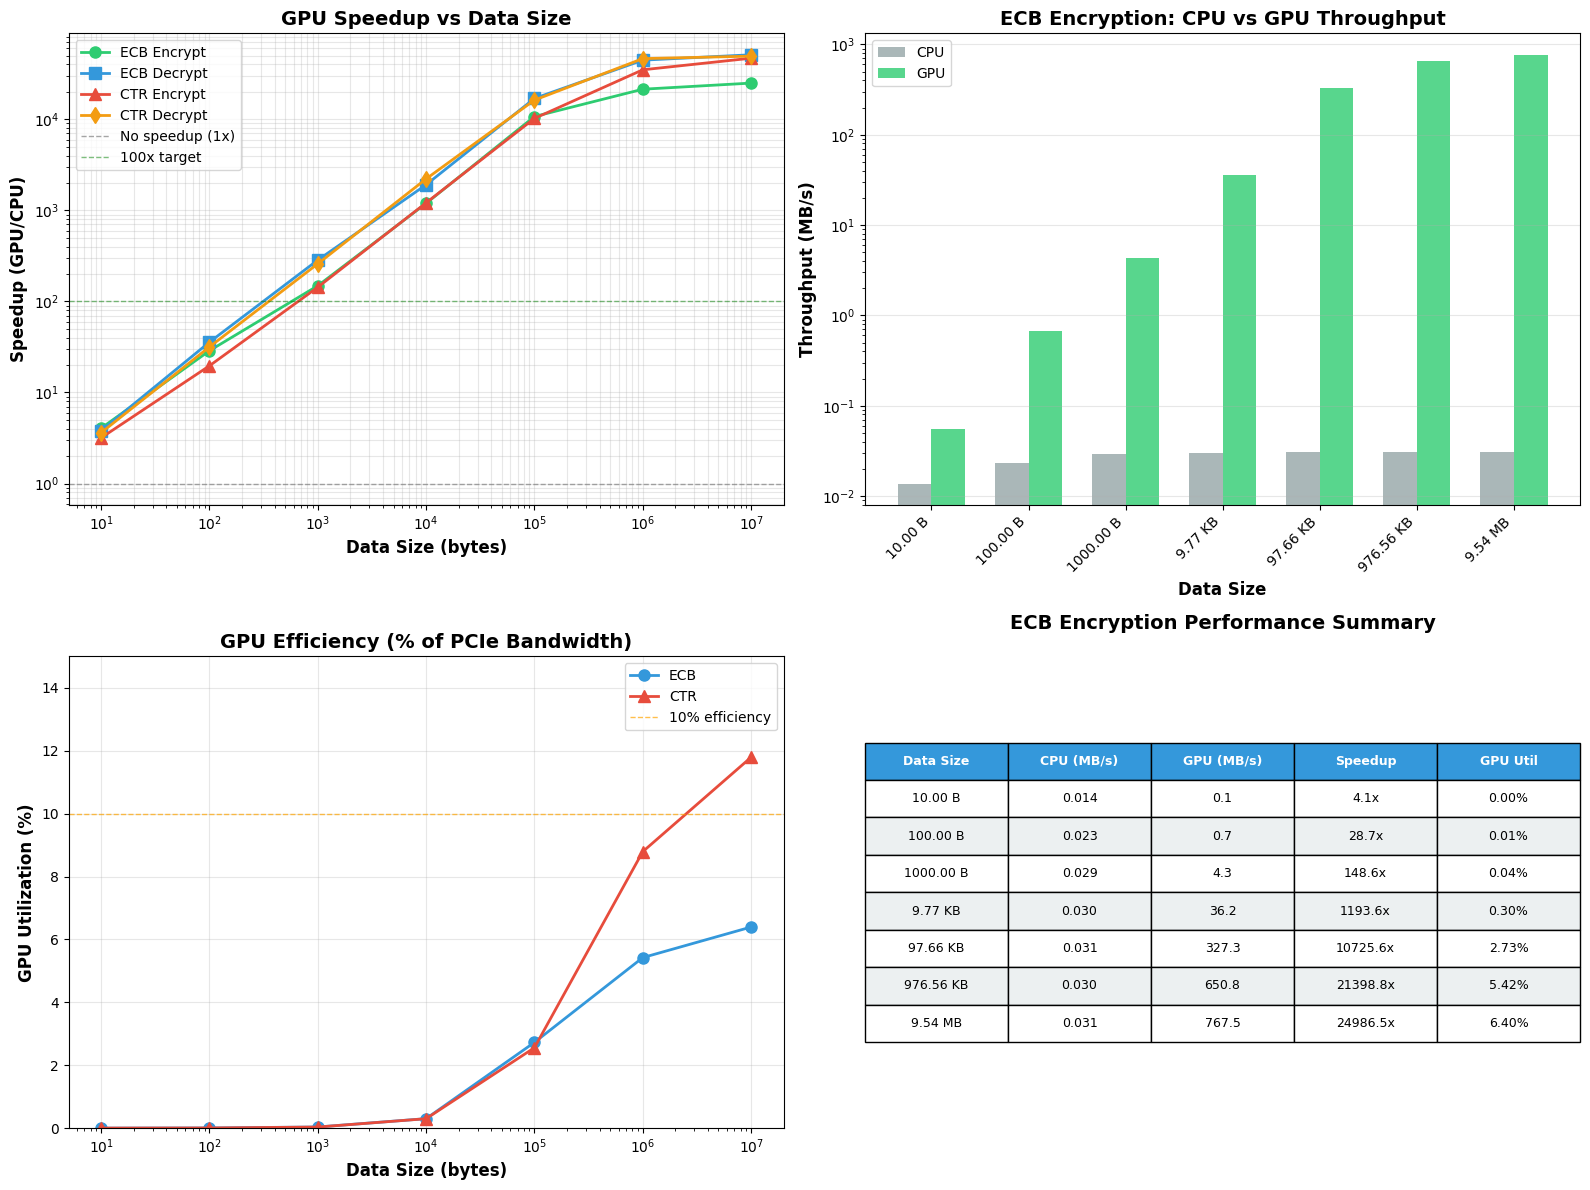


                         KEY PERFORMANCE INSIGHTS

Maximum Speedup: 24986.5x at 9.54 MB
   CPU: 0.031 MB/s
   GPU: 767.5 MB/s
   GPU Utilization: 6.40% of PCIe bandwidth

Speedup Trend:
   Small data (100 B):  4.05x (transfer overhead dominates)
   Medium data (10 KB): 1193.6x (balanced)
   Large data (9.54 MB): 24986.5x

Optimization Opportunities:
   Current max GPU throughput: 767.5 MB/s
   Theoretical PCIe peak: 12000 MB/s
   Headroom: 15.6x improvement possible



In [11]:
# Speedup Scaling Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Calculate speedups
ecb_enc_speedup = [gpu/cpu for cpu, gpu in zip(ecb_results['cpu_enc'], ecb_results['gpu_enc'])]
ecb_dec_speedup = [gpu/cpu for cpu, gpu in zip(ecb_results['cpu_dec'], ecb_results['gpu_dec'])]
ctr_enc_speedup = [gpu/cpu for cpu, gpu in zip(ctr_results['cpu_enc'], ctr_results['gpu_enc'])]
ctr_dec_speedup = [gpu/cpu for cpu, gpu in zip(ctr_results['cpu_dec'], ctr_results['gpu_dec'])]

# 1. Speedup vs Data Size (Log-Log)
ax1.loglog(ecb_results['sizes'], ecb_enc_speedup, 'o-', linewidth=2, markersize=8, label='ECB Encrypt', color='#2ecc71')
ax1.loglog(ecb_results['sizes'], ecb_dec_speedup, 's-', linewidth=2, markersize=8, label='ECB Decrypt', color='#3498db')
ax1.loglog(ctr_results['sizes'], ctr_enc_speedup, '^-', linewidth=2, markersize=8, label='CTR Encrypt', color='#e74c3c')
ax1.loglog(ctr_results['sizes'], ctr_dec_speedup, 'd-', linewidth=2, markersize=8, label='CTR Decrypt', color='#f39c12')
ax1.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='No speedup (1x)')
ax1.axhline(y=100, color='green', linestyle='--', linewidth=1, alpha=0.5, label='100x target')
ax1.set_xlabel('Data Size (bytes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Speedup (GPU/CPU)', fontsize=12, fontweight='bold')
ax1.set_title('GPU Speedup vs Data Size', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3, which='both')

# 2. Absolute Throughput Comparison
x_pos = np.arange(len(ecb_results['sizes']))
width = 0.35

# Convert to MB/s for readability
ecb_cpu_mbs = [x / 1e6 for x in ecb_results['cpu_enc']]
ecb_gpu_mbs = [x / 1e6 for x in ecb_results['gpu_enc']]

ax2.bar(x_pos - width/2, ecb_cpu_mbs, width, label='CPU', color='#95a5a6', alpha=0.8)
ax2.bar(x_pos + width/2, ecb_gpu_mbs, width, label='GPU', color='#2ecc71', alpha=0.8)
ax2.set_xlabel('Data Size', fontsize=12, fontweight='bold')
ax2.set_ylabel('Throughput (MB/s)', fontsize=12, fontweight='bold')
ax2.set_title('ECB Encryption: CPU vs GPU Throughput', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([format_bytes(size) for size in ecb_results['sizes']], rotation=45, ha='right')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_yscale('log')

# 3. GPU Efficiency (% of theoretical peak)
# Assume PCIe Gen3 x16: ~12 GB/s = 12,000 MB/s theoretical
theoretical_peak = 12000  # MB/s
ecb_gpu_efficiency = [x / (theoretical_peak * 1e6) * 100 for x in ecb_results['gpu_enc']]
ctr_gpu_efficiency = [x / (theoretical_peak * 1e6) * 100 for x in ctr_results['gpu_enc']]

ax3.semilogx(ecb_results['sizes'], ecb_gpu_efficiency, 'o-', linewidth=2, markersize=8, label='ECB', color='#3498db')
ax3.semilogx(ctr_results['sizes'], ctr_gpu_efficiency, '^-', linewidth=2, markersize=8, label='CTR', color='#e74c3c')
ax3.axhline(y=10, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='10% efficiency')
ax3.set_xlabel('Data Size (bytes)', fontsize=12, fontweight='bold')
ax3.set_ylabel('GPU Utilization (%)', fontsize=12, fontweight='bold')
ax3.set_title('GPU Efficiency (% of PCIe Bandwidth)', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 15])

# 4. Performance Summary Table
summary_data = []
for i, size in enumerate(ecb_results['sizes']):
    summary_data.append([
        format_bytes(size),
        f"{ecb_results['cpu_enc'][i]/1e6:.3f}",
        f"{ecb_results['gpu_enc'][i]/1e6:.1f}",
        f"{ecb_enc_speedup[i]:.1f}x",
        f"{ecb_gpu_efficiency[i]:.2f}%"
    ])

table = ax4.table(cellText=summary_data,
                  colLabels=['Data Size', 'CPU (MB/s)', 'GPU (MB/s)', 'Speedup', 'GPU Util'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.2, 0.2, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(5):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(summary_data) + 1):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')

ax4.axis('off')
ax4.set_title('ECB Encryption Performance Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('aes_speedup_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print key insights
print("\n" + "="*80)
print(" "*25 + "KEY PERFORMANCE INSIGHTS")
print("="*80)

max_speedup_idx = ecb_enc_speedup.index(max(ecb_enc_speedup))
max_speedup_size = ecb_results['sizes'][max_speedup_idx]
max_speedup_value = ecb_enc_speedup[max_speedup_idx]

print(f"\nMaximum Speedup: {max_speedup_value:.1f}x at {format_bytes(max_speedup_size)}")
print(f"   CPU: {ecb_results['cpu_enc'][max_speedup_idx]/1e6:.3f} MB/s")
print(f"   GPU: {ecb_results['gpu_enc'][max_speedup_idx]/1e6:.1f} MB/s")
print(f"   GPU Utilization: {ecb_gpu_efficiency[max_speedup_idx]:.2f}% of PCIe bandwidth")

print(f"\nSpeedup Trend:")
print(f"   Small data (100 B):  {ecb_enc_speedup[0]:.2f}x (transfer overhead dominates)")
if len(ecb_enc_speedup) > 3:
    print(f"   Medium data (10 KB): {ecb_enc_speedup[3]:.1f}x (balanced)")
print(f"   Large data ({format_bytes(ecb_results['sizes'][-1])}): {ecb_enc_speedup[-1]:.1f}x")

print(f"\nOptimization Opportunities:")
print(f"   Current max GPU throughput: {max(ecb_results['gpu_enc'])/1e6:.1f} MB/s")
print(f"   Theoretical PCIe peak: {theoretical_peak} MB/s")
print(f"   Headroom: {theoretical_peak / (max(ecb_results['gpu_enc'])/1e6):.1f}x improvement possible")

print("\n" + "="*80)